In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
%matplotlib inline
plt.rcParams.update({'font.size': 14})
%config InlineBackend.figure_format = 'retina'

In [3]:
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2017GL075860
glhymps = gpd.read_file('../Data/GLHYMPS/GLHYMPS/GLHYMPS.gdb')
glhymps = glhymps.to_crs('ESRI:54030')
glhymps['geomx'] = glhymps.geometry.centroid.x
glhymps['geomy'] = glhymps.geometry.centroid.y

In [4]:
usa = gpd.read_file('../Data/maps_and_boundaries/US_state_outline/cb_2018_us_state_500k.shp').to_crs('ESRI:54030')

In [5]:
glhymps_usa = glhymps[(glhymps.geomx>-1.25e7) &
       (glhymps.geomx<-0.5e7) &
       (glhymps.geomy>2.5e6) &
       (glhymps.geomy<7e6)]#.head(1000000).plot()

In [6]:
joined = gpd.sjoin(glhymps_usa,usa,how='right')

In [7]:
joined = joined.merge(glhymps[['IDENTITY_','geometry']],left_on='IDENTITY_',
                     right_on='IDENTITY_',how='left')
joined = joined[['IDENTITY_','Shape_Length','Shape_Area','Porosity','Permeability_no_permafrost',
                'Permeability_permafrost','Permeability_standard_deviation','geometry_y']]

In [8]:
joined = gpd.GeoDataFrame(joined, geometry=joined.geometry_y)

In [9]:
# limit to only gagesII points
gagesII = gpd.read_file('../Data/gagesII_data_and_subsets/gagesII.shp').to_crs('ESRI:54030')

In [27]:
# bring in shapefile of gagesII basins
gagesII_basins = gpd.read_file('../Data/boundaries-shapefiles-by-aggeco/bas_ref_all.shp')
for f in ['bas_nonref_AKHIPR.shp',
         'bas_nonref_CntlPlains.shp',
         'bas_nonref_EastHghlnds.shp',
         'bas_nonref_MxWdShld.shp',
         'bas_nonref_NorthEast.shp',
         'bas_nonref_SECstPlain.shp',
         'bas_nonref_SEPlains.shp',
         'bas_nonref_WestMnts.shp',
         'bas_nonref_WestPlains.shp',
         'bas_nonref_WestXeric.shp']:
    gagesII_temp = gpd.read_file('../Data/boundaries-shapefiles-by-aggeco/'+f)
    gagesII_basins = pd.concat([gagesII_basins,gagesII_temp])
gagesII_basins = gagesII_basins[gagesII_basins.GAGE_ID.isin(gagesII.STAID)]

In [11]:
gagesII_basins1 = gpd.sjoin(gagesII_basins.to_crs('ESRI:54030'),joined.set_crs('ESRI:54030'),how='left')

In [12]:
gagesII_basins1['weightedPorosity'] = (gagesII_basins1.Porosity*gagesII_basins1.Shape_Area)
gagesII_basins1['weightedPermeability'] = gagesII_basins1.Permeability_permafrost*gagesII_basins1.Shape_Area
gagesII_basins1['weighted_Perm_stdev'] = gagesII_basins1.Permeability_standard_deviation*gagesII_basins1.Shape_Area

gages_areas = gagesII_basins1.groupby('GAGE_ID').sum().Shape_Area
gages_means = gagesII_basins1.groupby('GAGE_ID').mean().drop(columns=['Shape_Length','index_right',
                                                                     'Shape_Area','Porosity','Permeability_no_permafrost',
                                                                     'Permeability_permafrost','Permeability_standard_deviation'])

gages_means['weighted_areas'] = gages_areas
gages_means['Porosity'] = gages_means.weightedPorosity/gages_means.weighted_areas
gages_means['Permeability_permafrost'] = gages_means.weightedPermeability/gages_means.weighted_areas
gages_means['Permeability_standard_deviation'] = gages_means.weighted_Perm_stdev/gages_means.weighted_areas
gages_means = gages_means.drop(columns=['weightedPorosity','weightedPermeability','weighted_Perm_stdev'])

In [13]:
gages_means = gages_means.reset_index()

In [15]:
# gagesII_join = gpd.sjoin(gagesII,joined.set_crs('ESRI:54030'),how='left')

In [17]:
# gagesII_join = gagesII_join[['STAID','STANAME','LAT_GAGE','LNG_GAGE','geometry','Porosity',
#              'Permeability_no_permafrost','Permeability_permafrost','Permeability_standard_deviation',
#              'geometry_y']]

In [18]:
# calculate hydraulic conductivity, K
# K = k*rho*g/mu [m/s]
# k = permeability (10^(k_reported/100)) [m2]
# rho = 999.97 kg/m3
# g = 9.81 m/s2
# mu = 1e-3
gagesII_join = gages_means

gagesII_join['hydraulic_conductivity'] = 10**(gagesII_join['Permeability_permafrost'])*1e7
gagesII_join['hydraulic_conductivity_min'] = 10**((gagesII_join.Permeability_permafrost-
                                             gagesII_join.Permeability_standard_deviation))*1e7
gagesII_join['hydraulic_conductivity_max'] = 10**((gagesII_join.Permeability_permafrost+
                                             gagesII_join.Permeability_standard_deviation))*1e7
# gagesII_join['hydraulic_conductivity_std'] = (gagesII_join.hydraulic_conductivity_max-gagesII_join.hydraulic_conductivity_min)/2

In [22]:
gagesII_join.to_csv('gagesII_join_aquifer_params.csv',index=False)

# ----------------------------------
## Now we don't have to redo the calculations above this line again

In [32]:
gagesII_join = pd.read_csv('gagesII_join_aquifer_params.csv')
gagesII = gpd.read_file('../Data/gagesII_data_and_subsets/gagesII.shp').to_crs('EPSG:4326')
# bring in shapefile of gagesII basins
gagesII_basins = gpd.read_file('../Data/boundaries-shapefiles-by-aggeco/bas_ref_all.shp')
for f in ['bas_nonref_AKHIPR.shp',
         'bas_nonref_CntlPlains.shp',
         'bas_nonref_EastHghlnds.shp',
         'bas_nonref_MxWdShld.shp',
         'bas_nonref_NorthEast.shp',
         'bas_nonref_SECstPlain.shp',
         'bas_nonref_SEPlains.shp',
         'bas_nonref_WestMnts.shp',
         'bas_nonref_WestPlains.shp',
         'bas_nonref_WestXeric.shp']:
    gagesII_temp = gpd.read_file('../Data/boundaries-shapefiles-by-aggeco/'+f)
    gagesII_basins = pd.concat([gagesII_basins,gagesII_temp])
gagesII_basins = gagesII_basins[gagesII_basins.GAGE_ID.isin(gagesII.STAID)]
gagesII_basins = gagesII_basins.to_crs('EPSG:4326')

In [3]:
# import depth to bedrock data
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0169748
# https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016MS000686
# http://globalchange.bnu.edu.cn/research/dtbd.jsp


import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
test = rasterio.open('../Data/bigfiles/BDTICM_M_1km_ll.tif')

In [ ]:
plt.imshow(test.read(1)/100,vmin = 0,vmax = 250)
plt.colorbar()

In [34]:
gagesII_join['GAGE_ID'] = gagesII_join.GAGE_ID.astype('int')
gagesII['STAID'] = gagesII.STAID.astype('int')
gagesII_basins['GAGE_ID'] = gagesII_basins.GAGE_ID.astype('int')

In [37]:
gagesII_join = gagesII_join.merge(gagesII_basins[['GAGE_ID','geometry']],left_on='GAGE_ID',
                  right_on='GAGE_ID',how='left')

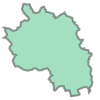

In [40]:
gagesII_join.geometry.iloc[0]

In [46]:
from rasterstats import zonal_stats

DTB_zonal_stats = zonal_stats(gagesII_join.geometry, '../Data/bigfiles/BDTICM_M_1km_ll.tif')



In [50]:
DTB_zonal_mean = [DTB_zonal_stats[i]['mean']/100 for i in range(len(DTB_zonal_stats))]

In [ ]:
# gagesII_reproj = gagesII_join.to_crs('EPSG:4326')
# print('total',len(gagesII_reproj))
# DTB = []
# for i in range(len(gagesII_reproj)):
#     print(i)
#     try:
#         xycoord = test.index(gagesII_reproj.geometry.centroid.x.values[i],
#                gagesII_reproj.geometry.centroid.y.values[i])
#         DTB.append((test.read(1)[xycoord[0]][xycoord[1]])/100)
#     except:
#         DTB.append(np.nan)

(array([241.,  62.,   4.,   1.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([  3.55286275,  20.22083915,  36.88881556,  53.55679197,
         70.22476838,  86.89274479, 103.5607212 , 120.22869761,
        136.89667402, 153.56465043, 170.23262684]),
 <BarContainer object of 10 artists>)

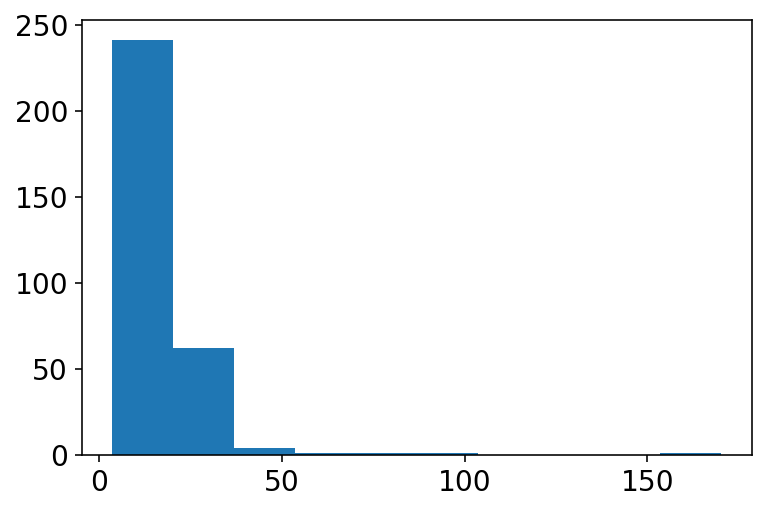

In [54]:
plt.hist(DTB_zonal_mean)
# gagesII_reproj['DTB'] = DTB

In [55]:
gagesII_join['DTB'] = DTB_zonal_mean

In [56]:
# calculate transmissivity, T
# T = K b

gagesII_join['Transmissivity'] = gagesII_join.hydraulic_conductivity*gagesII_join.DTB

In [60]:
gagesII_join = gagesII_join.merge(gagesII[['STAID','LAT_GAGE','STANAME','LNG_GAGE']],left_on='GAGE_ID',
                  right_on='STAID',how='left')

In [61]:
gagesII_join[['GAGE_ID','STANAME','LAT_GAGE','LNG_GAGE','Porosity','Transmissivity']].to_csv('../Data/GAGESII_aquifer_params.csv')

In [ ]:
# calculate storativity, S